In [159]:
import pandas as pd
import numpy as np
import torch
import warnings
from src.plot_utils import *
from src.space_model import space_model
from src.nn_model import nnModel
from src.plot_utils import *
from matplotlib import animation
from moviepy.editor import *
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [160]:
df1 = pd.read_json('./Data/sample_match_1_with_v.json')
e_df1 = pd.read_json('./Data/sample_Game_1_events.json')

In [161]:
df = pd.read_json('./Data/sample_match_1_w_sog.json')

In [162]:
df

,Period,Frame,Time [s],H11_x,H11_y,H1_x,H1_y,H2_x,H2_y,H3_x,...,A2_sq,A4_sq,A3_sq,H14_sq,A13_sq,H13_sq,H3_sq,A5_sq,H1_sq,frame
0,1,1,0.04,0.08528,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,26,1.04,0.06656,32.72976,33.68144,42.30824,34.59560,32.38772,32.77352,...,-0.000435,-0.006917,0.002523,NaN,NaN,NaN,-0.001775,-0.014185,0.005273,26
2,1,51,2.04,-0.02080,32.65768,33.14584,39.65284,34.02568,31.30992,32.86712,...,0.009205,0.016325,0.026593,NaN,NaN,NaN,0.001070,0.001996,-0.006292,51
3,1,76,3.04,0.10088,32.68896,33.17912,38.00588,34.04856,31.44524,32.99192,...,0.016404,-0.002440,0.041138,NaN,NaN,NaN,0.001161,0.001419,-0.006415,76
4,1,101,4.04,0.73632,32.80116,33.81040,39.06464,34.33976,33.44376,33.41936,...,0.001777,0.015791,-0.031569,NaN,NaN,NaN,0.003969,-0.024722,-0.009595,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,2,144901,5796.04,100.73440,28.43352,NaN,NaN,37.57832,44.05652,33.76568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144901
5797,2,144926,5797.04,99.02360,29.55892,NaN,NaN,37.35264,44.18232,32.98672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144926
5798,2,144951,5798.04,97.42512,30.57280,NaN,NaN,36.87112,44.32784,33.29248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144951
5799,2,144976,5799.04,95.72576,31.11816,NaN,NaN,36.24400,44.24420,32.88896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144976


In [163]:
import re

In [164]:
player_regx = re.compile('[HA][0-9]+_[xy]$')
player_regx2 = re.compile('[HA][0-9]+_sq$')


In [165]:
def space_generation(frame_idx, df):
    frame = (frame_idx + 4) * 25 + 1
    past_frame = frame - 100
    p_list = [i for i in df.columns if re.match(player_regx, i)]
    past_loc_dict = df[df['Frame'] == past_frame].reset_index(drop=True).loc[0, p_list].to_dict()
    present_loc_dict = df[df['Frame'] == frame].reset_index(drop=True).loc[0, p_list].to_dict()
    past_loc_dict = {k:v for k, v in past_loc_dict.items() if not math.isnan(v)}
    present_loc_dict = {k:v for k, v in present_loc_dict.items() if not math.isnan(v)}

    if list(past_loc_dict.keys()) != list(present_loc_dict.keys()):
        print('player changed')
        return

    player_list = list(set([i.split('_')[0] for i in past_loc_dict.keys()]))
    past_loc = np.zeros(shape=(22, 2))
    present_loc = np.zeros(shape=(22, 2))
    
    for i, p in enumerate(player_list):
        past_loc[i, 0] = past_loc_dict[p+'_x']
        past_loc[i, 1] = past_loc_dict[p+'_y']

        present_loc[i, 0] = present_loc_dict[p+'_x']
        present_loc[i, 1] = present_loc_dict[p+'_y']

    sog_list = [i+'_sq' for i in player_list]
    sog = np.array(list(df[df['Frame'] == frame].reset_index(drop=True).loc[0, sog_list].to_dict().values()))
    
    return player_list, past_loc, present_loc, sog

In [166]:
def distance_m(a, b):
    output = np.tile(np.sum(b**2, axis=1), (b.shape[0], 1)) 
    output -= 2 * np.matmul(a, b.T)
    output += np.tile(np.sum(a**2, axis=1).reshape(-1, 1), b.shape[0])
    return np.sqrt(output)

In [167]:
df

,Period,Frame,Time [s],H11_x,H11_y,H1_x,H1_y,H2_x,H2_y,H3_x,...,A2_sq,A4_sq,A3_sq,H14_sq,A13_sq,H13_sq,H3_sq,A5_sq,H1_sq,frame
0,1,1,0.04,0.08528,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,26,1.04,0.06656,32.72976,33.68144,42.30824,34.59560,32.38772,32.77352,...,-0.000435,-0.006917,0.002523,NaN,NaN,NaN,-0.001775,-0.014185,0.005273,26
2,1,51,2.04,-0.02080,32.65768,33.14584,39.65284,34.02568,31.30992,32.86712,...,0.009205,0.016325,0.026593,NaN,NaN,NaN,0.001070,0.001996,-0.006292,51
3,1,76,3.04,0.10088,32.68896,33.17912,38.00588,34.04856,31.44524,32.99192,...,0.016404,-0.002440,0.041138,NaN,NaN,NaN,0.001161,0.001419,-0.006415,76
4,1,101,4.04,0.73632,32.80116,33.81040,39.06464,34.33976,33.44376,33.41936,...,0.001777,0.015791,-0.031569,NaN,NaN,NaN,0.003969,-0.024722,-0.009595,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,2,144901,5796.04,100.73440,28.43352,NaN,NaN,37.57832,44.05652,33.76568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144901
5797,2,144926,5797.04,99.02360,29.55892,NaN,NaN,37.35264,44.18232,32.98672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144926
5798,2,144951,5798.04,97.42512,30.57280,NaN,NaN,36.87112,44.32784,33.29248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144951
5799,2,144976,5799.04,95.72576,31.11816,NaN,NaN,36.24400,44.24420,32.88896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144976


In [168]:
SOG_passive = {}
SOG_active = {}
for j in [i.split('_')[0] for i in df.columns if '_sq' in i]:
    p_value = 0
    a_value = 0
    for k in range(len(df)):
        if df.loc[k, j+'_sq'] >= 0.1: 
            if df.loc[k, j+'_v_abs'] >= 5.4:
                p_value += 1
            else :
                a_value += 1

    SOG_passive[j] = p_value
    SOG_active[j] = a_value    

In [169]:
aa= np.array([[[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]], [[4, 5, 6],
       [7, 8, 9],
       [10, 11, 12]], [[13, 14, 15],
       [16, 17, 18],
       [19, 20, 21]]])

In [170]:
#### distance_m 검증

a = np.array([[1, 2], [2, 1], [3, 2]])
distance_m(a, a)

array([[0.        , 1.41421356, 2.        ],
       [1.41421356, 0.        , 1.41421356],
       [2.        , 1.41421356, 0.        ]])

In [171]:
#### np.whare 검증
np.where(distance_m(a, a)>1.5, 1, 0)

array([[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]])

In [172]:
np.tile(np.where(distance_m(a, a)>1.5, 1, 0), (3, 1, 1))

array([[[0, 0, 1],
        [0, 0, 0],
        [1, 0, 0]],

       [[0, 0, 1],
        [0, 0, 0],
        [1, 0, 0]],

       [[0, 0, 1],
        [0, 0, 0],
        [1, 0, 0]]])

In [173]:
##### reshape 검증

np.where(distance_m(a, a)>1.5, 1, 0).reshape(3,3,1)

array([[[0],
        [0],
        [1]],

       [[0],
        [0],
        [0]],

       [[1],
        [0],
        [0]]])

In [174]:
np.tile(np.where(distance_m(a, a)>1.5, 1, 0), (3, 1, 1)) * np.where(distance_m(a, a)>1.5, 1, 0).reshape(3,3,1)

array([[[0, 0, 0],
        [0, 0, 0],
        [1, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 1],
        [0, 0, 0],
        [0, 0, 0]]])

In [175]:
#4868

4868

4868

In [182]:
space_gen_dict = {}
space_gen_list = []
for f in range(len(df)):
    try:
        player_list, past_loc, present_loc, sog = space_generation(f, df)
    
    except:
        continue
    
    present_distance = distance_m(present_loc, present_loc)
    past_distance = distance_m(past_loc, past_loc)

    a = np.tile(np.where(past_distance<5, 1, 0) * np.where(present_distance>5, 1, 0), (22, 1, 1))
    b = a * (np.where(present_distance<5, 1, 0) * np.where(past_distance - present_distance > 2, 1, 0)).reshape(22, 22, 1)
    c = b * np.where(sog>0.1, 1, 0)

    for i in range(22):
        for j in range(22):
            for k in range(22):
                if c[i][j][k] != 0:
                    if player_list[i].startswith('H') and player_list[j].startswith('A') and player_list[k].startswith('H'):
                        if player_list[i] not in space_gen_dict.keys():
                            space_gen_dict[player_list[i]] = [0, 0]
                        if player_list[k] not in space_gen_dict.keys():
                            space_gen_dict[player_list[k]] = [0, 0]
                        
                        space_gen_dict[player_list[i]][1] += 1
                        space_gen_dict[player_list[k]][0] += 1
                         
                        space_gen_list.append((player_list[i], player_list[j], player_list[k], (f + 4) * 25 + 1))
                        print('i : {}, j : {}, i\' : {}, frame : {}'.format(player_list[i], player_list[j], player_list[k], (f + 4) * 25 + 1))
                    elif player_list[i].startswith('A') and player_list[j].startswith('H') and player_list[k].startswith('A'):
                        if player_list[i] not in space_gen_dict.keys():
                            space_gen_dict[player_list[i]] = [0, 0]
                        if player_list[k] not in space_gen_dict.keys():
                            space_gen_dict[player_list[k]] = [0, 0]
                        
                        space_gen_dict[player_list[i]][1] += 1
                        space_gen_dict[player_list[k]][0] += 1


                        space_gen_list.append((player_list[i], player_list[j], player_list[k], (f + 4) * 25 + 1))
                        print('i : {}, j : {}, i\' : {}, frame : {}'.format(player_list[i], player_list[j], player_list[k], (f + 4) * 25 + 1))

i : A10, j : H2, i' : A7, frame : 401
i : A10, j : H1, i' : A7, frame : 476
i : A10, j : H3, i' : A9, frame : 1176
i : A9, j : H1, i' : A5, frame : 5351
i : A4, j : H2, i' : A5, frame : 5776
i : A6, j : H6, i' : A7, frame : 6926
i : A4, j : H8, i' : A5, frame : 7376
i : H7, j : A5, i' : H10, frame : 8701
i : A9, j : H3, i' : A10, frame : 8976
i : A9, j : H3, i' : A10, frame : 9001
i : H8, j : A5, i' : H9, frame : 10576
i : H8, j : A3, i' : H9, frame : 10576
i : H7, j : A7, i' : H8, frame : 10626
i : H7, j : A7, i' : H3, frame : 10626
i : H8, j : A6, i' : H3, frame : 10626
i : H8, j : A4, i' : H9, frame : 14726
i : A10, j : H4, i' : A7, frame : 15026
i : A7, j : H6, i' : A9, frame : 16126
i : H9, j : A1, i' : H8, frame : 17301
i : H1, j : A6, i' : H3, frame : 17326
i : H9, j : A6, i' : H3, frame : 17326
i : H1, j : A1, i' : H8, frame : 18251
i : H9, j : A1, i' : H8, frame : 18251
i : H9, j : A10, i' : H8, frame : 18251
i : H2, j : A3, i' : H9, frame : 18251
i : H2, j : A6, i' : H8, fram

In [183]:
t_df = pd.DataFrame(space_gen_dict).transpose()
t_df.columns = ['generation', 'receive']
t_df

,generation,receive
A10,5,7
A7,5,4
A9,17,12
A5,9,1
A4,3,8
A6,1,9
H7,0,3
H10,3,3
H8,11,8
H9,12,10


In [184]:
frame = 400

In [185]:
space_gen_list

[('A10', 'H2', 'A7', 401),
 ('A10', 'H1', 'A7', 476),
 ('A10', 'H3', 'A9', 1176),
 ('A9', 'H1', 'A5', 5351),
 ('A4', 'H2', 'A5', 5776),
 ('A6', 'H6', 'A7', 6926),
 ('A4', 'H8', 'A5', 7376),
 ('H7', 'A5', 'H10', 8701),
 ('A9', 'H3', 'A10', 8976),
 ('A9', 'H3', 'A10', 9001),
 ('H8', 'A5', 'H9', 10576),
 ('H8', 'A3', 'H9', 10576),
 ('H7', 'A7', 'H8', 10626),
 ('H7', 'A7', 'H3', 10626),
 ('H8', 'A6', 'H3', 10626),
 ('H8', 'A4', 'H9', 14726),
 ('A10', 'H4', 'A7', 15026),
 ('A7', 'H6', 'A9', 16126),
 ('H9', 'A1', 'H8', 17301),
 ('H1', 'A6', 'H3', 17326),
 ('H9', 'A6', 'H3', 17326),
 ('H1', 'A1', 'H8', 18251),
 ('H9', 'A1', 'H8', 18251),
 ('H9', 'A10', 'H8', 18251),
 ('H2', 'A3', 'H9', 18251),
 ('H2', 'A6', 'H8', 18251),
 ('H3', 'A2', 'H1', 18251),
 ('H3', 'A2', 'H9', 18251),
 ('H8', 'A5', 'H9', 26601),
 ('A6', 'H7', 'A5', 27876),
 ('A5', 'H5', 'A7', 27901),
 ('A6', 'H7', 'A9', 27901),
 ('H4', 'A7', 'H9', 31201),
 ('A4', 'H8', 'A5', 35301),
 ('A6', 'H7', 'A5', 35301),
 ('A4', 'H8', 'A5', 3532

In [186]:
[i for i in space_gen_list if i[3]-100 <= frame and frame <= i[3]]

[('A10', 'H2', 'A7', 401), ('A10', 'H1', 'A7', 476)]

In [187]:
pcmodel = pc_model() 
sp_model = space_model(df=df1, e_df=e_df1)

In [188]:
frame = 451
sp_model.set_frame(frame)

In [189]:
[i for i in space_gen_list if i[3]-100 <= frame and frame <= i[3]]

[('A10', 'H1', 'A7', 476)]

In [211]:
def snap_sgg(frame, figx=None):
    if figx == None:
        fig, ax = draw_pitch(pitch='white', line='black')
    else:
        fig, ax = figx
    
    
    sp_model.set_frame(frame)
    if sp_model.set_frame_flag:
        fig, ax, obj = pcmodel.plot_frame(frame, (fig, ax))

        sp_dict = {i:j for i,j in zip(sp_model.players, sp_model.points)}


        t_list = [sp for sp in space_gen_list if sp[3]-100 <= frame and frame <= sp[3]]
        for i in t_list:
            obj.append(ax.scatter(sp_dict[i[0]][0], sp_dict[i[0]][1], c='red', alpha=0.5, s=200))
            obj.append(ax.scatter(sp_dict[i[1]][0], sp_dict[i[1]][1], c='orange', alpha=0.5, s=200))
            obj.append(ax.scatter(sp_dict[i[2]][0], sp_dict[i[2]][1], c='white', alpha=0.5, s=200))
            obj.append(ax.arrow(sp_dict[i[1]][0], sp_dict[i[1]][1], sp_dict[i[0]][0]-sp_dict[i[1]][0], sp_dict[i[0]][1]-sp_dict[i[1]][1]))
    
    else :
        fig, ax, obj = pcmodel.plot_frame(frame, figx=(fig, ax))

    return fig, ax, obj

            

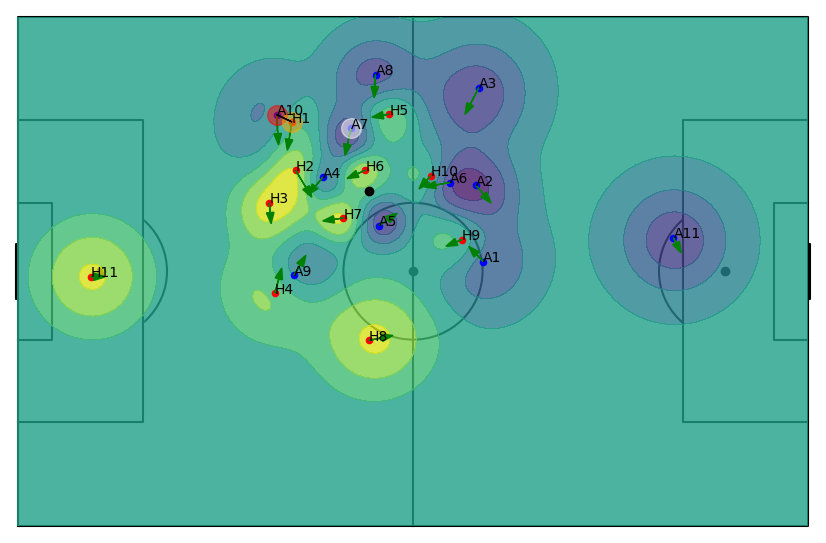

In [212]:
_, _, _ = snap_sgg(476)

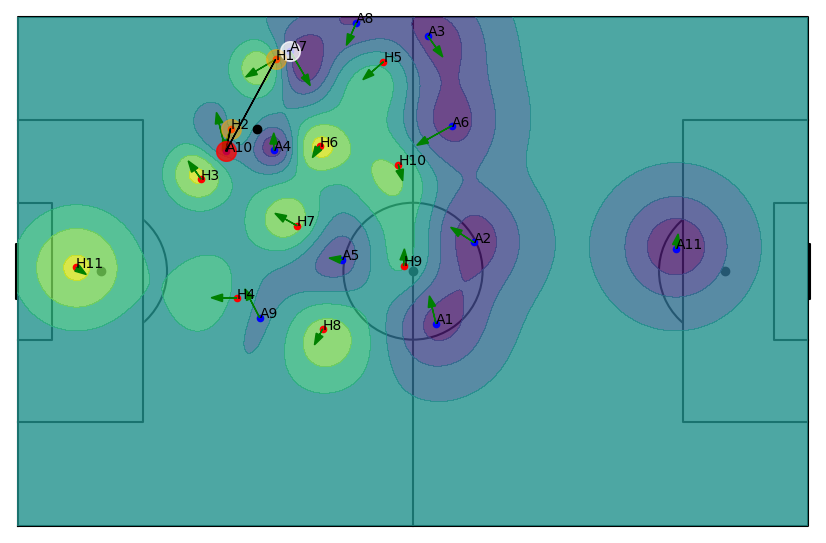

In [213]:
_, _, _ = snap_sgg(376)

done
done


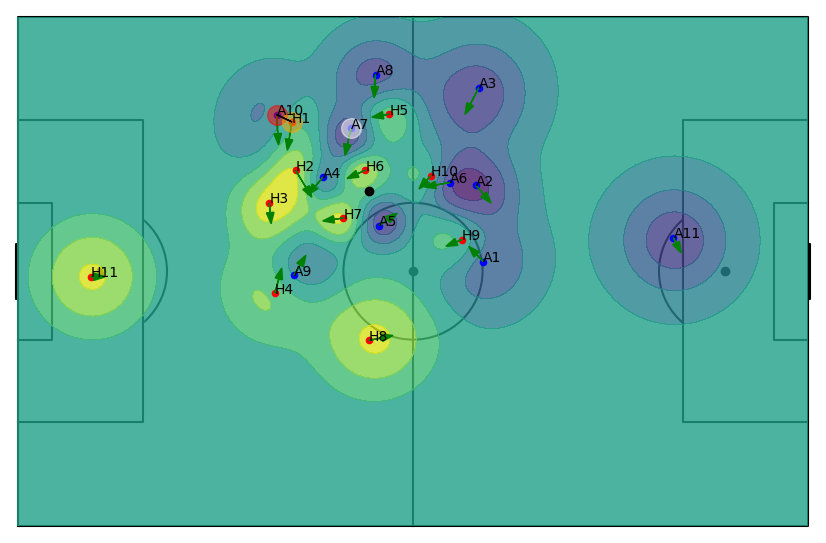

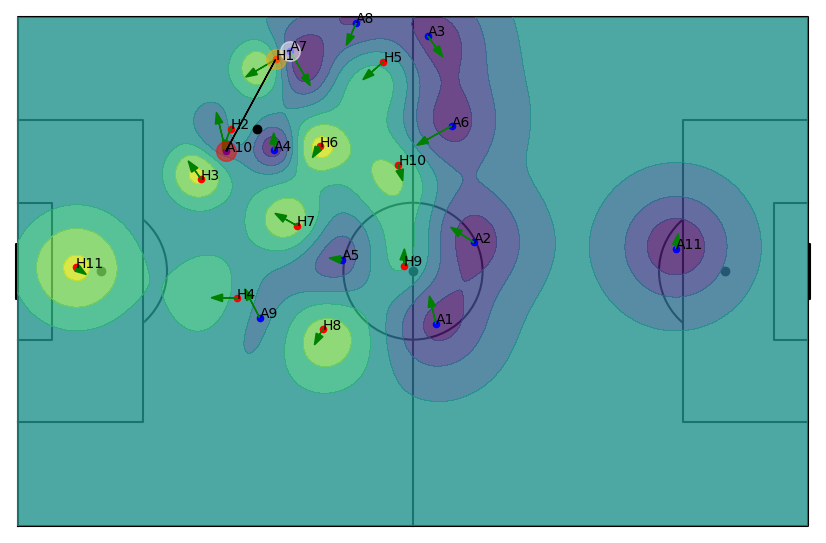

In [208]:
frame = 476
sp_model.set_frame(frame)
if sp_model.set_frame_flag:
    print('done')
_, ax, obj = pcmodel.plot_frame(frame)

sp_dict = {i:j for i,j in zip(sp_model.players, sp_model.points)}


t_list = [sp for sp in space_gen_list if sp[3]-100 <= frame and frame <= sp[3]]
for i in t_list:
    ax.scatter(sp_dict[i[0]][0], sp_dict[i[0]][1], c='red', alpha=0.5, s=200)
    ax.scatter(sp_dict[i[1]][0], sp_dict[i[1]][1], c='orange', alpha=0.5, s=200)
    ax.scatter(sp_dict[i[2]][0], sp_dict[i[2]][1], c='white', alpha=0.5, s=200)
    ax.arrow(sp_dict[i[1]][0], sp_dict[i[1]][1], sp_dict[i[0]][0]-sp_dict[i[1]][0], sp_dict[i[0]][1]-sp_dict[i[1]][1])

sp_model.set_frame(frame-100)
if sp_model.set_frame_flag:
    print('done')
_, ax, obj = pcmodel.plot_frame(frame-100)

sp_dict = {i:j for i,j in zip(sp_model.players, sp_model.points)}

t_list = [sp for sp in space_gen_list if sp[3]-100 <= frame and frame <= sp[3]]
for i in t_list:
    ax.scatter(sp_dict[i[0]][0], sp_dict[i[0]][1], c='red', alpha=0.5, s=200)
    ax.scatter(sp_dict[i[1]][0], sp_dict[i[1]][1], c='orange', alpha=0.5, s=200)
    ax.scatter(sp_dict[i[2]][0], sp_dict[i[2]][1], c='white', alpha=0.5, s=200)
    ax.arrow(sp_dict[i[1]][0], sp_dict[i[1]][1], sp_dict[i[0]][0]-sp_dict[i[1]][0], sp_dict[i[0]][1]-sp_dict[i[1]][1])

In [214]:
def save_plot_sgg(
    start_frame, end_frame, fname='test', fps=25, figax=None
):
    writer = animation.FFMpegWriter(fps=fps)

    if figax is None:
        fig, ax = draw_pitch(pitch='white', line='black')
    else:
        fig, ax = figax

    fig.set_tight_layout(True)

    with writer.saving(fig, fname, dpi=50):
        for frame in np.arange(start_frame, end_frame, 2):

            fig, ax, figobj = snap_sgg(frame, figx=(fig, ax))
                
            writer.grab_frame()
            for obj in figobj:
                if type(obj) == list:
                    obj[0].remove()
                else:
                    obj.remove()

    plt.clf()
    plt.close(fig)